## Comparação com Remuneração nominal

### Importação das bibliotecas e da base:

In [3]:
import pandas as pd
import numpy as np
import weightedstats as ws
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
agregado_vinculos = pd.read_csv("dados/agregado_vinculo")

### Análise no país:

#### 1) Variáveis e funções importantes

In [4]:
agrupado_sexo_ano = agregado_vinculos.groupby(by=[ "ano","sexo_trabalhador",])
agrupado_ano = agregado_vinculos.groupby("ano")
agrupado_sexo_ano_idade = agregado_vinculos.groupby(by=[ "idade","ano","sexo_trabalhador",])
def pondera_media(row):
    return np.average(row["valor_remun_media_nominal"], weights=row["numero_vinculos"])

def pondera_mediana(df):
    return ws.numpy_weighted_median(df["valor_remun_media_nominal"], weights=df["numero_vinculos"])


#### 2) Comparação das médias no ano

In [5]:
media_rm_br = agrupado_sexo_ano.apply(pondera_media).rename("Média da Remuneração Nominal")
media_rm_br

ano   sexo_trabalhador
1999  1                    750.499641
      2                    609.478229
2009  1                   1588.113883
      2                   1318.641555
2019  1                   3158.481449
      2                   2724.355038
Name: Média da Remuneração Nominal, dtype: float64

#### 3) Comparação da mediana no ano

In [6]:
mediana_rm_br = agrupado_sexo_ano.apply(pondera_mediana).rename("Mediana da Remuneração Nominal")
mediana_rm_br

ano   sexo_trabalhador
1999  1                    454.801889
      2                    387.360000
2009  1                    947.475000
      2                    804.134000
2019  1                   1967.100000
      2                   1714.187500
Name: Mediana da Remuneração Nominal, dtype: float64

#### 4) Tabela completa: média e mediana

In [7]:
newMultIndex = [(gen, ano) for ano in (1999, 2009, 2019) for gen in ("Homens", "Mulheres")] 
descricao_sexo_ano = pd.concat([media_rm_br, mediana_rm_br], axis=1)
descricao_sexo_ano.index = pd.MultiIndex.from_tuples(newMultIndex)
descricao_sexo_ano

,,Média da Remuneração Nominal,Mediana da Remuneração Nominal
Homens,1999,750.499641,454.801889
Mulheres,1999,609.478229,387.360000
Homens,2009,1588.113883,947.475000
Mulheres,2009,1318.641555,804.134000
Homens,2019,3158.481449,1967.100000
Mulheres,2019,2724.355038,1714.187500


#### 5) Salário da mulher em relação ao homem durante os anos

In [8]:
dict_diff_rm = {}
for ano in (1999, 2009, 2019):
    media_homens = descricao_sexo_ano["Média da Remuneração Nominal"][("Homens", ano)]
    media_mulheres= descricao_sexo_ano["Média da Remuneração Nominal"][("Mulheres", ano)]
    mediana_homens = descricao_sexo_ano["Mediana da Remuneração Nominal"][("Homens", ano)]
    mediana_mulheres= descricao_sexo_ano["Mediana da Remuneração Nominal"][("Mulheres", ano)]
    dict_diff_rm[ano] = [
        f"{(1 - media_mulheres/media_homens) * 100:.2f}%",
        f"{(1 - mediana_mulheres/mediana_homens) * 100:.2f}%"
    ]

salario_mulherxhomem = pd.DataFrame(dict_diff_rm, index=["Média", "Mediana"])
salario_mulherxhomem

,1999,2009,2019
Média,18.79%,16.97%,13.74%
Mediana,14.83%,15.13%,12.86%


#### 6) Salário nominal de acordo com a idade

In [9]:
rm_nominal_idade = agrupado_sexo_ano_idade["valor_remun_media_nominal"].mean().unstack(level=[1, 2])

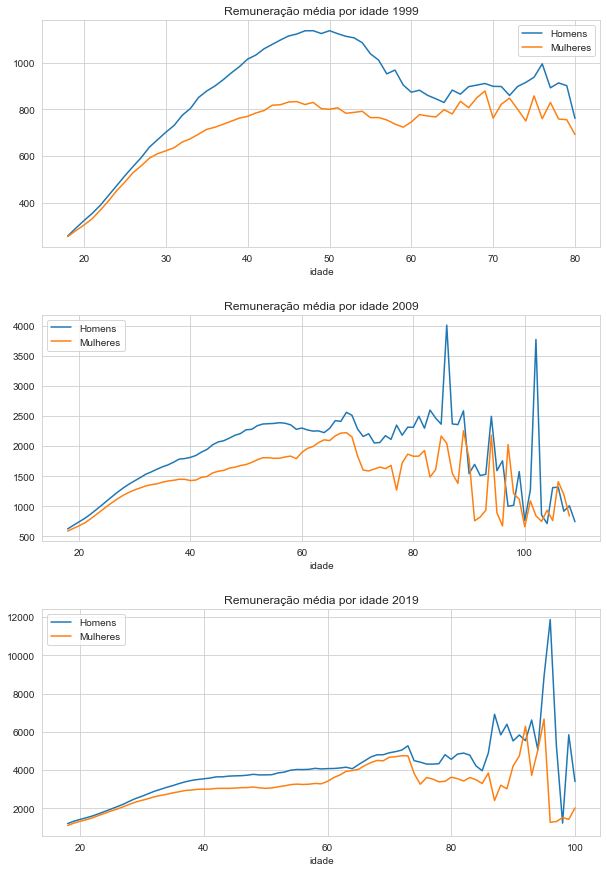

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(hspace=0.3)
for index, ano in enumerate([1999, 2009, 2019]):
    titulo = f"Remuneração média por idade {ano}"
    rm_nominal_idade[ano].plot(kind="line", ax=axes[index], figsize=(10, 15), title=titulo)
    axes[index].legend(["Homens", "Mulheres"])

### Análise nas regiões:

#### 1) Variáveis e funções importantes

In [11]:
regioes= {
    "norte": ["AC", "AP", "AM", "PA", "RO", "RR", "TO"],
    "nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
    "centro_oeste": ["DF", "GO", "MT", "MS"],
    "sudeste":["RJ", "SP", "MG", "ES"],
    "sul": ["PR", "RS", "SC"]
}

def aplicalog(linha):
    return np.log10(linha["valor_remun_media_nominal"])



#### 2) Redução da desigualdade salarial nas regiões de 1999 até 2019

In [12]:
dict_diff_rm_reg = {}

for reg in regioes:
    vinculos_reg = agregado_vinculos.loc[agregado_vinculos["sigla_uf"].isin(regioes[reg])]
    vinculos_reg =  vinculos_reg.groupby(by=["ano", "sexo_trabalhador"]).apply(pondera_media)
    vinculos_reg_porc_1999 = (vinculos_reg[(1999, 2)]/vinculos_reg[(1999, 1)])
    vinculos_reg_porc_2019 = (vinculos_reg[(2019, 2)]/vinculos_reg[(2019, 1)])
    dict_diff_rm_reg[reg] =  [f"{(1 - vinculos_reg_porc_1999) * 100:.2f}%", f"{(1 - vinculos_reg_porc_2019) * 100:.2f}%"]

salario_mulherxhomem_reg = pd.DataFrame(dict_diff_rm_reg, index=["1999", "2019"])
salario_mulherxhomem_reg


,norte,nordeste,centro_oeste,sudeste,sul
1999,13.79%,18.66%,8.65%,18.25%,20.64%
2019,5.37%,4.56%,9.01%,17.10%,15.87%


#### 3) Distribuição dos salários na região nordeste em 2019

In [61]:
agregados_nordeste_2019 = agregado_vinculos[
    (agregado_vinculos["sigla_uf"].isin(regioes["nordeste"])) &
    (agregado_vinculos["ano"] == 2019)
]

nordeste_2019_rem_log = agregados_nordeste_2019.apply(aplicalog, axis=1)
nordeste_2019_rem_log = nordeste_2019_rem_log.rename("valor_remun_media_nominal_log")
nordeste_2019_rem_log

4961        3.025306
4962        3.042166
4963        3.022552
4964        3.067316
4965        3.022519
              ...   
39389694    3.131360
39389695    3.137060
39389696    3.124648
39389697    3.137329
39389698    3.583414
Name: valor_remun_media_nominal_log, Length: 3515714, dtype: float64

In [62]:
agregados_nordeste_2019_log = pd.concat([agregados_nordeste_2019["sexo_trabalhador"], nordeste_2019_rem_log], axis=1)
agregados_nordeste_2019_log

,sexo_trabalhador,valor_remun_media_nominal_log
4961,1,3.025306
4962,2,3.042166
4963,2,3.022552
4964,2,3.067316
4965,1,3.022519
...,...,...
39389694,2,3.131360
39389695,2,3.137060
39389696,2,3.124648
39389697,2,3.137329


Text(0.5, 1.0, 'Distribuição da Remuneração Nominal por Sexo em 2019 na Região Nordeste')

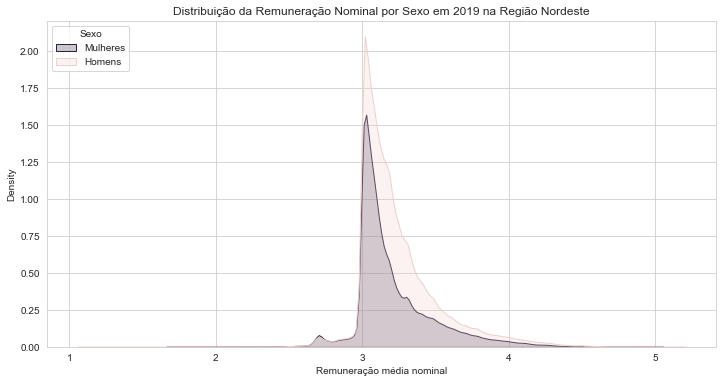

In [65]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=agregados_nordeste_2019_log, shade=True, x="valor_remun_media_nominal_log", hue="sexo_trabalhador")

plt.xlabel("Remuneração média nominal")
plt.legend(title='Sexo', loc='upper left', labels=['Mulheres', 'Homens'])
plt.title("Distribuição da Remuneração Nominal por Sexo em 2019 na Região Nordeste")

#### 4) Distribuição dos salários na região sudeste em 2019

In [50]:
agregados_sudeste_2019 = agregado_vinculos[
    (agregado_vinculos["sigla_uf"].isin(regioes["sudeste"])) &
    (agregado_vinculos["ano"] == 2019)
]

sudeste_2019_rem_log = agregados_sudeste_2019.apply(aplicalog, axis=1)
sudeste_2019_rem_log = sudeste_2019_rem_log.rename("valor_remun_media_nominal_log")
sudeste_2019_rem_log

75386       3.012200
75387       3.291398
75388       3.396647
75389       3.178227
75390       3.043087
              ...   
39706127    3.393296
39706128    3.456499
39706129    3.344373
39706130    3.443303
39706131    3.431954
Length: 8157395, dtype: float64

In [54]:
agregados_sudeste_2019_log = pd.concat([agreagados_sudeste_2019["sexo_trabalhador"], sudeste_2019_rem_log], axis=1)
agregados_sudeste_2019_log

,sexo_trabalhador,valor_remun_media_nominal_log
75386,2,3.012200
75387,1,3.291398
75388,1,3.396647
75389,1,3.178227
75390,1,3.043087
...,...,...
39706127,1,3.393296
39706128,1,3.456499
39706129,2,3.344373
39706130,1,3.443303


Text(0.5, 1.0, 'Distribuição da Remuneração Nominal por Sexo em 2019 na Região Sudeste')

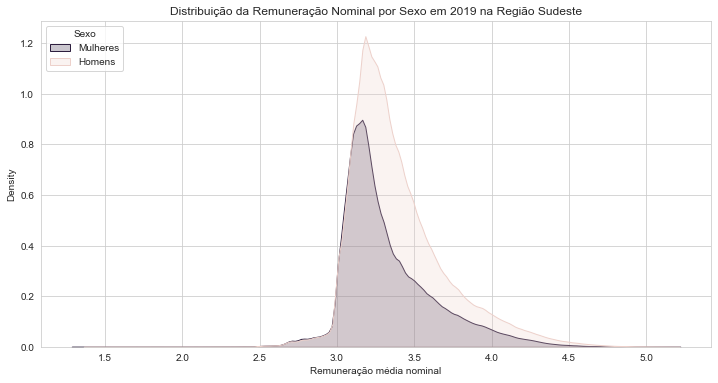

In [68]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=agregados_sudeste_2019_log, shade=True, x="valor_remun_media_nominal_log", hue="sexo_trabalhador")

plt.xlabel("Remuneração média nominal")
plt.legend(title='Sexo', loc='upper left', labels=['Mulheres', 'Homens'])
plt.title("Distribuição da Remuneração Nominal por Sexo em 2019 na Região Sudeste")